# Import Libraries and Data

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

In [54]:
df = pd.read_csv('gold_silver_oil.csv', header=0, index_col=0, parse_dates=True)
df.head()

,Gold,Silver,Oil
DateTime,,,
2019-01-01,1281.0,15.54,46.540001
2019-01-02,1291.8,15.71,47.090000
2019-01-03,1282.7,15.69,47.959999
2019-01-06,1286.8,15.67,48.520000
2019-01-07,1283.2,15.63,49.779999


# Exploratory Data Analysis

In [55]:
import statsmodels.tsa.api as smt
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

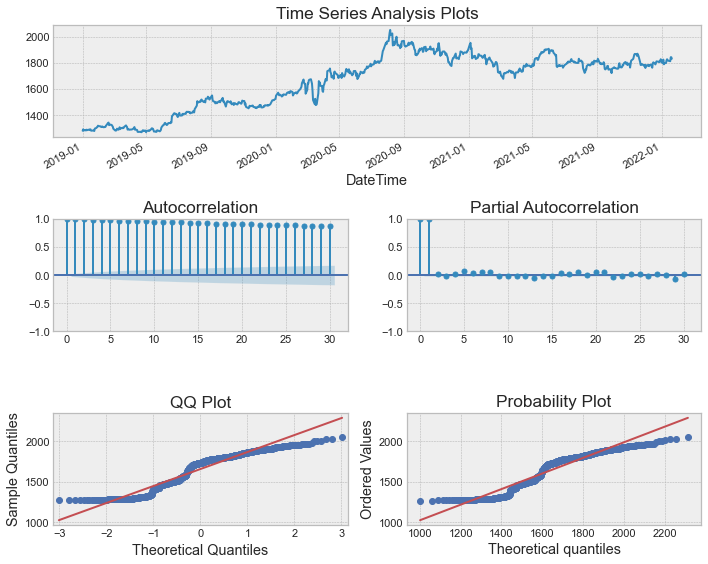

In [56]:
tsplot(df['Gold'], lags=30)

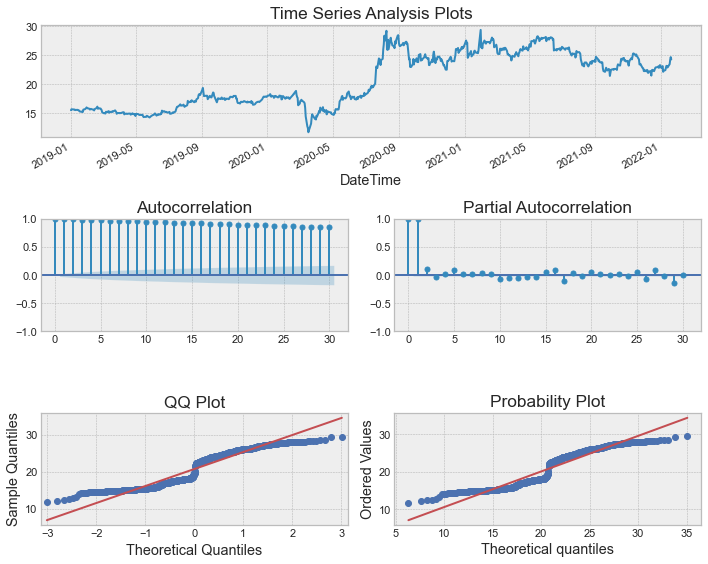

In [57]:
tsplot(df['Silver'], lags=30)

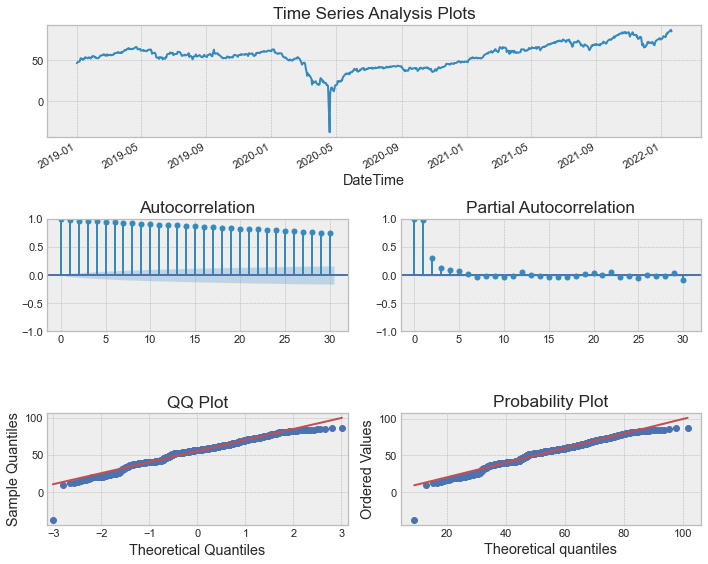

In [58]:
tsplot(df['Oil'], lags=30)

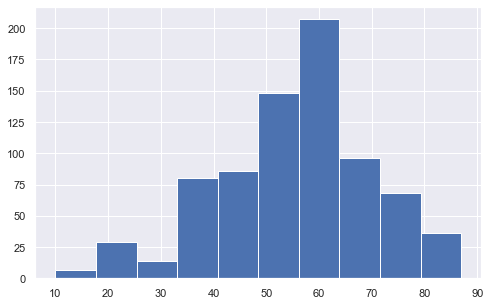

In [59]:
df = df[df['Oil'] > 0]
df['Oil'].hist(figsize=(8,5));

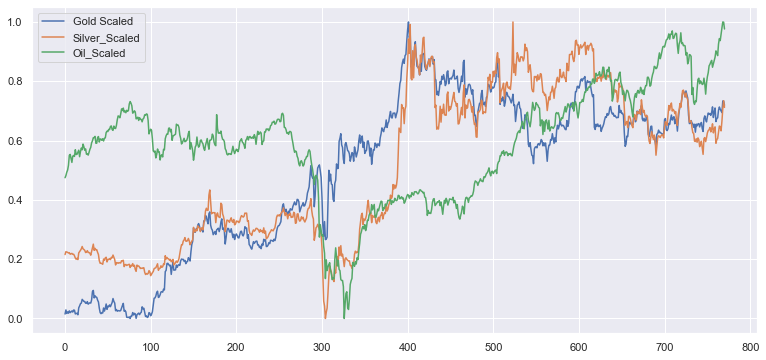

In [60]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
scaled_values = mm.fit_transform(df)
df_scaled = pd.DataFrame(scaled_values, columns=('Gold Scaled', 'Silver_Scaled', 'Oil_Scaled'))
df_scaled.plot(figsize=(13,6));

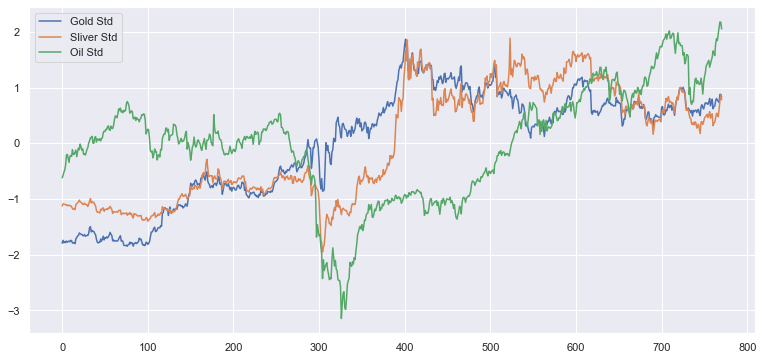

In [61]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
std_values = sc.fit_transform(df)
df_std = pd.DataFrame(std_values, columns=('Gold Std', 'Sliver Std', 'Oil Std'))
df_std.plot(figsize=(13,6));

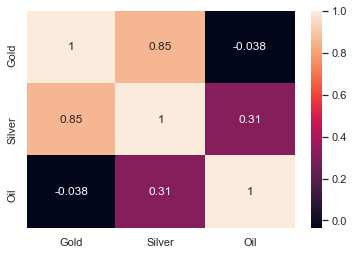

In [62]:
sns.heatmap(df.corr(), annot=True);

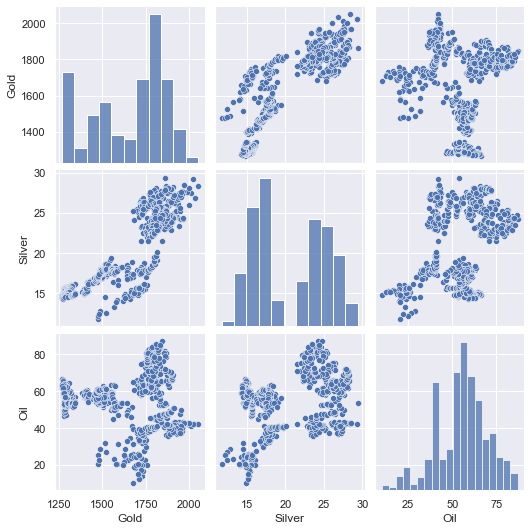

In [63]:
_ = sns.pairplot(df)

# Error Metrics

In [64]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def rmse(actual, pred):
    return np.sqrt(np.mean((actual - pred)**2))

# Baseline Methods

In [65]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

## Naive Forecast

### Walkforward Validation

In [66]:
def naive_forecast_walkforward(train, test):
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        yhat = history[-1]
        predictions.append(yhat)
        history.append(test[i])
    return predictions

In [67]:
def evaluate_forecast(actuals, predictions):
    rmse_result = rmse(actuals, predictions)
    mae_result = mean_absolute_error(actuals, predictions)
    mape_result = mape(actuals, predictions)

    print('MAPE: %.2f%%' % mape_result)
    print('RMSE: %.2f' % rmse_result)
    print('MAE: %.2f' % mae_result)

    plt.figure(figsize=(10,5))
    plt.plot(actuals)
    plt.plot(predictions, 'r')
    plt.show();

In [68]:
series = 'Gold'
n_test = 10
X = df[series].values
train, test = train_test_split(X, n_test)

MAPE: 0.52%
RMSE: 13.01
MAE: 9.55


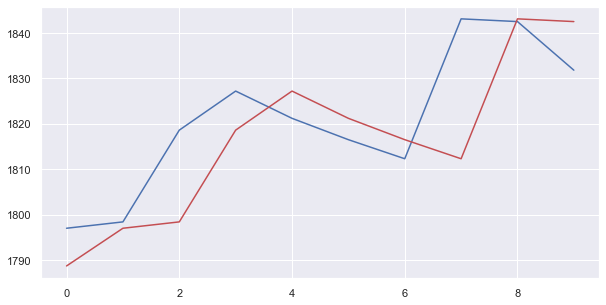

In [69]:
predictions = naive_forecast_walkforward(train,test)
evaluate_forecast(test, predictions)

### Multi-Step Forecast

MAPE: 1.76%
RMSE: 35.55
MAE: 32.16


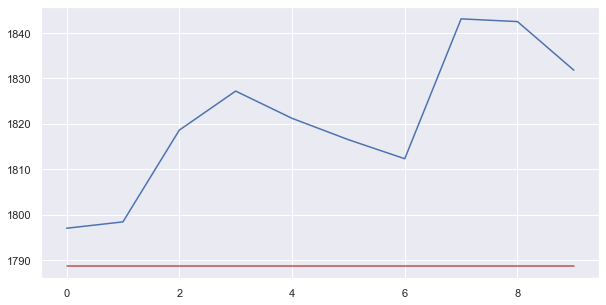

In [70]:
for x in range(len(predictions)):
    predictions[x] = predictions[0]
evaluate_forecast(test, predictions)

## Double Exponential Smoothing

In [71]:
def forecast(history, param_model):
    model = param_model(history)
    model_fit = model.fit(optimized=True)
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

### Walkforward Validation

In [72]:
def walkforward_val(history, test, param_model):
    predictions = list()
    history = [x for x in train]
    for i in range(len(test)):
        yhat = forecast(history, param_model)
        predictions.append(yhat)
        history.append(test[i])
    evaluate_forecast(test,predictions)

In [73]:
from statsmodels.tsa.holtwinters import Holt
holt = Holt(df[series])
result = holt.fit()
result.params

{'smoothing_level': 0.9956125946495544,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1280.3066837396204,
 'initial_trend': 0.7151435614877919,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

MAPE: 0.54%
RMSE: 13.11
MAE: 9.88


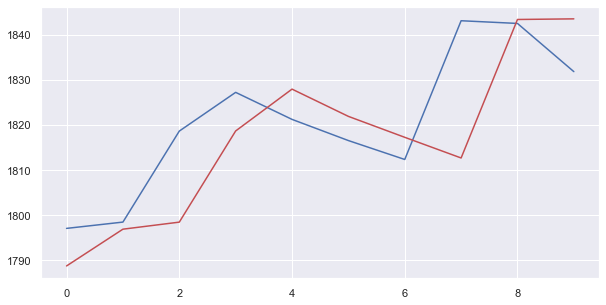

In [74]:
predictions = walkforward_val(train, test, Holt)

### Multi-Step Forecast

In [75]:
holt = Holt(train)
result = holt.fit(optimized=True)
predictions = result.predict(start=len(train)+1, end=len(train)+n_test)

MAPE: 1.83%
RMSE: 36.87
MAE: 33.38


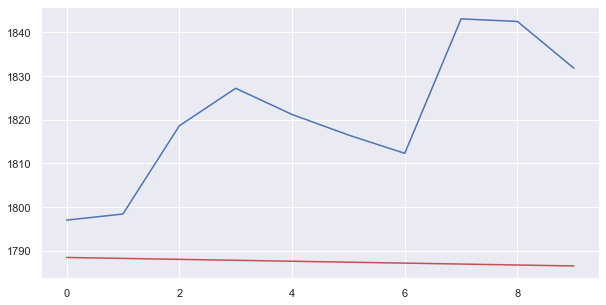

In [76]:
evaluate_forecast(test, predictions)

## ARIMA

In [77]:
import pmdarima as pm
model = pm.auto_arima(train[:],
                      trace=True,
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6536.848, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6535.277, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6537.270, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6537.269, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6534.349, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6534.283, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6535.131, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6535.251, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6539.207, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6539.222, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6534.364, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.141 seconds


In [78]:
from statsmodels.tsa.arima.model import ARIMA

In [79]:
X = df[series].values
train, test = train_test_split(X, n_test)

### Walkforward Validation

In [80]:
def walkforward_val_arima(history, test):
    predictions = list()
    history = [x for x in train]
    for i in range(len(test)):
        arima = ARIMA(history, order=(0,1,0))
        result = arima.fit()
        yhat = result.forecast()[0]
        predictions.append(yhat)
        history.append(test[i])
    
    return predictions

In [81]:
predictions = walkforward_val_arima(train, test)

MAPE: 0.52%
RMSE: 13.01
MAE: 9.55


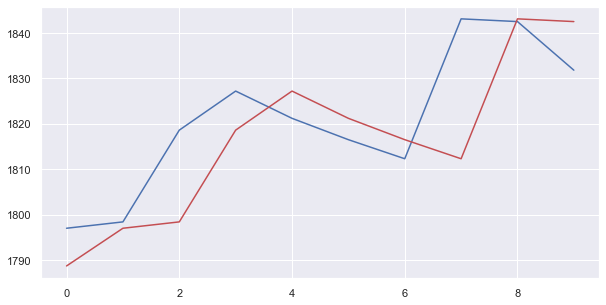

In [82]:
evaluate_forecast(test, predictions)

### Multi-Step Forecast

In [83]:
arima = ARIMA(train, order=(0,1,0))
result = arima.fit()
predictions = result.predict(start=len(train)+1, end=len(train)+n_test)

MAPE: 1.76%
RMSE: 35.55
MAE: 32.16


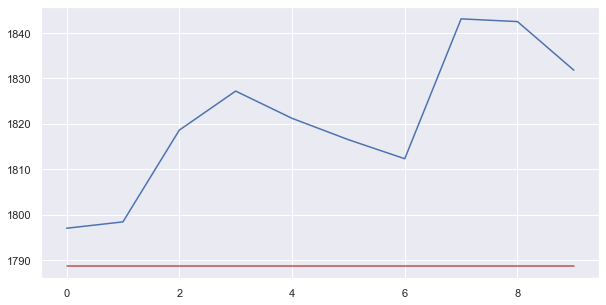

In [84]:
evaluate_forecast(test, predictions)

# Stationarity

In [85]:
from statsmodels.tsa.stattools import adfuller

def adf(x):
    res = adfuller(x)
    print("Test-Statistic:", res[0])
    print("P-Value:", res[1])
    if res[1] < 0.05:
        print("Stationary")
    else:
        print("Non-Stationary")

In [86]:
adf(df['Gold'])

Test-Statistic: -1.613630588242969
P-Value: 0.47607007549127234
Non-Stationary


In [87]:
adf(df['Silver'])

Test-Statistic: -1.4819803133236107
P-Value: 0.5424058436388229
Non-Stationary


In [88]:
adf(df['Oil'])

Test-Statistic: -0.7088222831016616
P-Value: 0.8444511141063591
Non-Stationary


In [89]:
df_diff = pd.DataFrame()
df_diff['Gold_Diff'] = df['Gold'].diff()
df_diff['Silver_Diff'] = df['Silver'].diff()
df_diff['Oil_Diff'] = df['Oil'].diff()
df_diff.dropna(how='any', inplace=True)

In [90]:
adf(df_diff['Gold_Diff'])

Test-Statistic: -13.800756465121768
P-Value: 8.580431338032252e-26
Stationary


In [91]:
adf(df_diff['Silver_Diff'])

Test-Statistic: -6.284192516731431
P-Value: 3.7326944689504456e-08
Stationary


In [92]:
adf(df_diff['Oil_Diff'])

Test-Statistic: -28.29462137261824
P-Value: 0.0
Stationary


# Granger Causality

In [93]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=20
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,Gold_x,Silver_x,Oil_x
Gold_y,1.0000,0.0002,0.2755
Silver_y,0.0000,1.0000,0.0378
Oil_y,0.0133,0.2186,1.0000


# VARMAX

### Parameter Selection - p

In [94]:
from statsmodels.tsa.api import VAR

In [95]:
train, test = train_test_split(df_diff, n_test)
train.drop(columns="Oil_Diff", inplace=True)
test.drop(columns="Oil_Diff", inplace=True)

In [96]:
model = VAR(train)
lag_order_result = model.select_order(maxlags=20)
lag_order_result.selected_orders

{'aic': 1, 'bic': 1, 'hqic': 1, 'fpe': 1}

### Parameter Selection - q

In [97]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [98]:
p = 1
for q in range(0,7):
    model = VARMAX(train, order=(p, q))
    result = model.fit(maxiter=10)
    print(q, result.aic)

0 6881.278587076569
1 6889.175594384413
2 6893.693405132679
3 6895.868983162057
4 6892.229650425659
5 6893.650467047181
6 6892.330739294635


### Walkforward Validation

In [99]:
p = 1
q = 0

pred_gold = np.array([])
pred_silver = np.array([])
history = train
    
for i in range(0,len(test)):

    model = VARMAX(history, order=(p,q))
    result = model.fit(maxiter=20)
    yhat = result.predict(start=len(history)+1,end=len(history)+1)

    pred_gold = np.append(pred_gold, yhat.values.flatten()[0])
    pred_silver = np.append(pred_silver, yhat.values.flatten()[1])
    history = history.append(test.iloc[0:1,:])

In [100]:
test['Gold_Pred_Undiff'] = np.zeros(len(test))
test['Silver_Pred_Undiff'] = np.zeros(len(test))

test['Gold_Pred_Undiff'][0] = df['Gold'][len(train['Gold_Diff'])] + pred_gold[0]
test['Silver_Pred_Undiff'][0] = df['Silver'][len(train['Silver_Diff'])] + pred_silver[0]

for i in range (1, len(test)):
    test['Gold_Pred_Undiff'][i] = test['Gold_Pred_Undiff'][i-1] + pred_gold[i]
    test['Silver_Pred_Undiff'][i] = test['Silver_Pred_Undiff'][i-1] + pred_silver[i]

In [101]:
df_train, df_test = train_test_split(df, n_test)

MAPE: 1.55%
RMSE: 31.35
MAE: 28.31


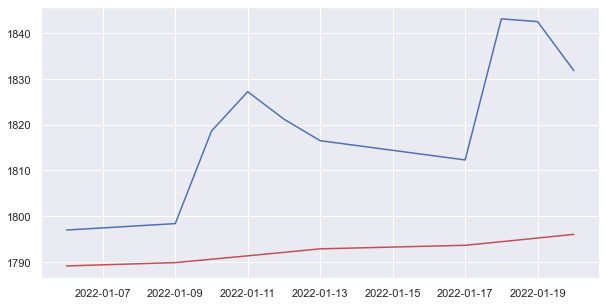

In [102]:
evaluate_forecast(df_test['Gold'], test['Gold_Pred_Undiff'])

MAPE: 4.80%
RMSE: 1.36
MAE: 1.14


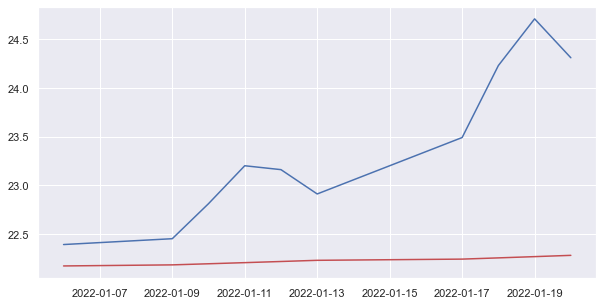

In [103]:
evaluate_forecast(df_test['Silver'], test['Silver_Pred_Undiff'])

# VARMAX Parameter Grid Search

In [104]:
test.drop(columns='Gold_Pred_Undiff', inplace=True)
test.drop(columns='Silver_Pred_Undiff', inplace=True)

In [59]:
print("p", "q", "rmse-g", "rmse-s")

for p in range(1,5):
    for q in range(1,5):
        pred_gold = np.array([])
        pred_silver = np.array([])
        history = train
        try:
            for i in range(0,len(test)):
                model = VARMAX(history, order=(p,q))
                result = model.fit(maxiter=10)
                yhat = result.predict(start=len(history)+1,end=len(history)+1)
                pred_gold = np.append(pred_gold, yhat.values.flatten()[0])
                pred_silver = np.append(pred_silver, yhat.values.flatten()[1])
                history = history.append(test.iloc[i-1:i,:])
            print(p, q, round(rmse(test['Gold_Diff'].values,pred_gold),3), round(rmse(test['Silver_Diff'].values,pred_silver),3))
        except:
            print(p, q, 'LinAlg Error')

p q rmse-g rmse-s
1 1 12.88 0.403
1 2 12.965 0.407
1 3 12.828 0.407
1 4 13.017 0.414
2 1 12.99 0.407
2 2 12.978 0.406
2 3 12.773 0.407
2 4 12.995 0.414
3 1 12.844 0.408
3 2 12.873 0.408
3 3 12.873 0.408
3 4 12.937 0.412
4 1 13.196 0.417
4 2 13.099 0.416
4 3 13.099 0.416
4 4 13.116 0.416


### Walkforward Validation

In [105]:
p = 2
q = 3

pred_gold = np.array([])
pred_silver = np.array([])
history = train
    
for i in range(0,len(test)):

    model = VARMAX(history, order=(p,q))
    result = model.fit(maxiter=20)
    yhat = result.predict(start=len(history)+1,end=len(history)+1)

    pred_gold = np.append(pred_gold, yhat.values.flatten()[0])
    pred_silver = np.append(pred_silver, yhat.values.flatten()[1])
    history = history.append(test.iloc[i-1:i,:])

In [106]:
test['Gold_Pred_Undiff'] = np.zeros(len(test))
test['Silver_Pred_Undiff'] = np.zeros(len(test))

test['Gold_Pred_Undiff'][0] = df['Gold'][len(train['Gold_Diff'])] + pred_gold[0]
test['Silver_Pred_Undiff'][0] = df['Silver'][len(train['Silver_Diff'])] + pred_silver[0]

for i in range (1, len(test)):
    test['Gold_Pred_Undiff'][i] = test['Gold_Pred_Undiff'][i-1] + pred_gold[i]
    test['Silver_Pred_Undiff'][i] = test['Silver_Pred_Undiff'][i-1] + pred_silver[i]

MAPE: 1.54%
RMSE: 31.08
MAE: 28.11


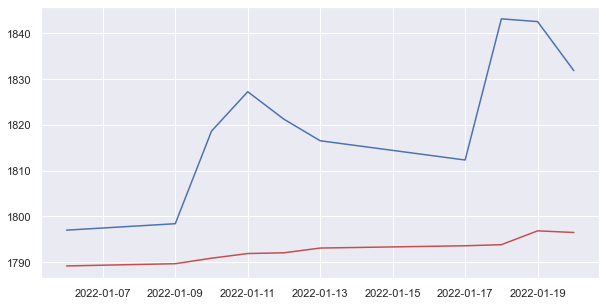

In [107]:
evaluate_forecast(df_test['Gold'], test['Gold_Pred_Undiff'])

MAPE: 4.92%
RMSE: 1.38
MAE: 1.17


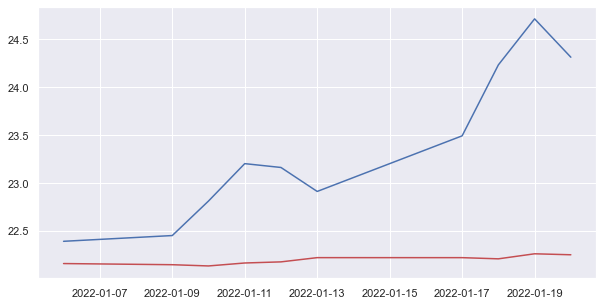

In [108]:
evaluate_forecast(df_test['Silver'], test['Silver_Pred_Undiff'])

### Multi-Step Forecast

In [109]:
p = 2
q = 3

model = VARMAX(train, order=(p,q))
result = model.fit(maxiter=20)
predictions = result.predict(start=len(train)+1,end=len(train)+len(test)+1)

In [110]:
test['Gold_Pred_Undiff'] = np.zeros(len(test))
test['Silver_Pred_Undiff'] = np.zeros(len(test))

test['Gold_Pred_Undiff'][0] = df['Gold'][len(train['Gold_Diff'])] + predictions['Gold_Diff'].values[0]
test['Silver_Pred_Undiff'][0] = df['Silver'][len(train['Silver_Diff'])] + predictions['Silver_Diff'].values[0]

for i in range (1, len(test)):
    test['Gold_Pred_Undiff'][i] = test['Gold_Pred_Undiff'][i-1] + predictions['Gold_Diff'].values[i]
    test['Silver_Pred_Undiff'][i] = test['Silver_Pred_Undiff'][i-1] + predictions['Silver_Diff'].values[i]

MAPE: 1.53%
RMSE: 31.05
MAE: 27.95


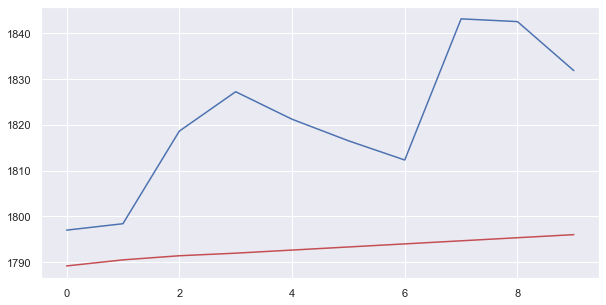

In [111]:
evaluate_forecast(df['Gold'].iloc[len(train)+1:].values,test['Gold_Pred_Undiff'].values)

MAPE: 4.96%
RMSE: 1.40
MAE: 1.18


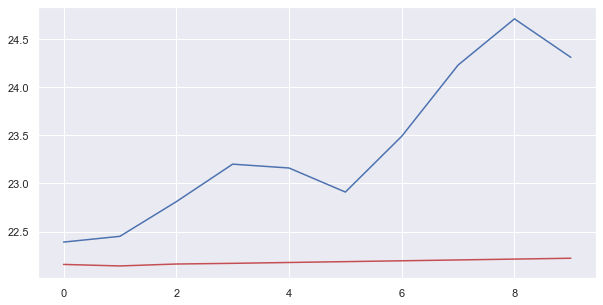

In [112]:
evaluate_forecast(df['Silver'].iloc[len(train)+1:].values,test['Silver_Pred_Undiff'].values)

# Ensembling

### Walkforward Validation

In [113]:
def naive_forecast_walkforward(train, test):
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        yhat = history[-1]
        predictions.append(yhat)
        history.append(test[i])
    return predictions

In [114]:
series = 'Gold'
n_test = 10
X = df[series].values
train, test = train_test_split(X, n_test)

MAPE: 0.52%
RMSE: 13.01
MAE: 9.55


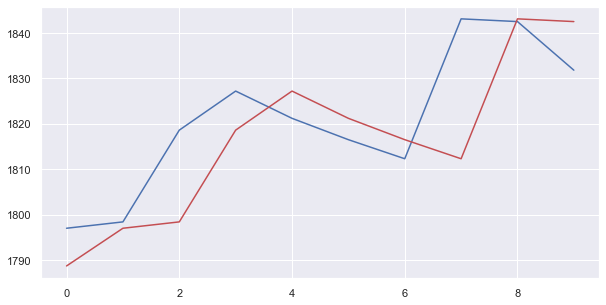

In [115]:
gold_pred = naive_forecast_walkforward(train,test)
evaluate_forecast(test, gold_pred)

In [116]:
combined = list()
for i in range(len(test)):
    yhat = (test[i] + gold_pred[i]) / 2
    combined.append(yhat)
combined

[1792.85,
 1797.7,
 1808.5,
 1822.9,
 1824.2,
 1818.85,
 1814.4,
 1827.6999999999998,
 1842.8,
 1837.15]

MAPE: 0.26%
RMSE: 6.50
MAE: 4.78


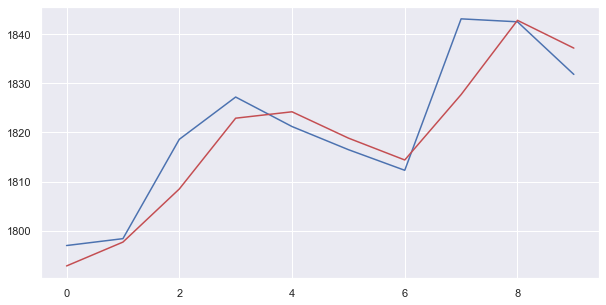

In [117]:
evaluate_forecast(test,combined)